# Project: No-show Appointments in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This notebook performs data analysis on the **No-show appointments** dataset from Kaggle. 

The dataset contains 13 data points for 110,527 historic medical appointments in Brazil, ranging from the date the appointment was booked for to whether the patient was sent an SMS reminder. The final, 14th data point per appointment indicates whether the patient showed up to the appointment or not (i.e. was a 'no-show'). 

The dataset is focused on investigating which factors are important for determining whether an appointment was a no-show. This is an important question, since no-shows are both a waste of medical system resources and potentially make care less available to those in more urgent need. 

According to the dataset's description on Kaggle, the 13 independent variables are:
- **PatientId**
- **AppointmentID**
- **Gender** 
- **ScheduledDay:** The date the appointment was booked (can be the same day)
- **AppointmentDay:** The date of the actual appointment
- **Age**
- **Neighbourhood:** Where the appointment took place (not necessarily the patient's own neighbourhood)
- **Scholarship:** Is the patient enrolled in the Brazilian welfare program *Bolsa Familia*?
- **Hipertension:** Does the patient suffer from hypertension? 
- **Diabetes:** Does the patient suffer from diabetes?
- **Alcoholism:** Does the patient suffer from alcoholism?
- **Handcap:** How many handicaps does the patient have? (Note: clarified by the dataset's owner in a comment on Kaggle)
- **SMS_received:** Did the patient receive at least one SMS reminder?

The dependent (14th) variable is:
- **No-show:** Was the patient a no-show?

This is therefore a *classification* problem, and numerous questions could be investigated here. However, this notebook does not make use of inferential statistics or machine learning techniques and, instead, focuses on exploring associations related to the following broad questions:
1. *Are older or younger individuals more likely to be no-shows?*
2. *Are men or women more likely to be no-shows?*
3. *Are those on welfare more or less likely to be no-shows?*
4. *Does having a medical condition or handicap make being a no-show more or less likely?*
5. *To what extent does booking in advance change the likelihood of no-shows?* 

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

The **General Properties** section identifies the following data cleaning tasks, which are then conducted in the **Data Cleaning** section:

- Column renaming
- Remove rows with negative ages
- Optimise datatypes
- Drop unnecessary columns for the questions identified previously
- Add useful (derived) columns

### General Properties

In [2]:
# Load data from .csv in this directory

df = pd.read_csv('no_show_appointments.csv')

The dataset has 110,527 rows (appointments) and 14 columns (13 independent variables and a 'No-show' dependent variable).

In [3]:
# View DataFrame dimensions and preview

print('Num. appointments:\t', df.shape[0])
print('Num. columns:\t\t', df.shape[1])
print('\nFirst 5 rows:')
df.head()

Num. appointments:	 110527
Num. columns:		 14

First 5 rows:


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


It is clear that the column names contain spelling mistakes, ambiguities (e.g. 'Handcap' is not boolean but, rather, a count of the number of handicaps the patient has) and inconsistent conventions (e.g. upper camel case vs. pythonic underscores). For consistency, and to avoid bugs later in the notebook, these should be fixed.

> **TASK:** Rename columns

Looking at the data itself, we first note that the dataset does not contain any null values or duplicated rows.

In [4]:
# Count nulls and duplicates

num_nulls = len(df.index) - len(df.dropna().index)
num_duplicates = sum(df.duplicated())

print('Num. nulls:\t', num_nulls)
print('Num. duplicates:', num_duplicates)

Num. nulls:	 0
Num. duplicates: 0


Next, generate summary statistics for the data to check for any issues:
- Overall statistics
- Number of unique values

In [5]:
# Overall statistics

df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [6]:
# Number of unique values

df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

First, note that each of the appointment IDs are unique, which implies that the dataset does not feature the same appointment more than once, as desired. Should the same appointment ID appear more than once, but with different associated characteristics, this could indicate an issue that the previous duplicate count would not have detected. 

By contrast, the data does feature patients who booked multiple appointments in the period, as is to be expected. This could be used for analysing the likelihood of a patient missing an appointment if they missed a previous appointment, for example, although such analysis is not conducted in this notebook. Instead, it is left as an avenue for future work. 

Next, note that the boolean variables appear not to include any errors since each has only two unique values (M/F for gender, and 0/1 otherwise). These tables also emphasise that the 'Handcap' variable refers to the number of handicaps an individual has, rather than simply whether they are handicapped in any way, as discussed previously.

One **issue**, however, is that age has an (impossible) minimum value of -1. There are, in addition, a number of age 0 patients: 

In [7]:
# Number of patients with an age of -1 or 0

print('Num age 0:\t', len(df.query('Age == 0').index))
print('Num age -1:\t', len(df.query('Age == -1').index))

print('\nAge -1 appointment details:')
df.query('Age == -1')

Num age 0:	 3539
Num age -1:	 1

Age -1 appointment details:


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


- **Age 0:** Since there are 3539 age 0 patients, it seems unlikely that this is an error: instead it is probably referring to prenatal care. 
- **Age -1:** Although there is nothing obviously wrong about other fields for the patient's appointment, this still seems likely to be an error and should therefore be removed. 

> **TASK:** Remove row with age == -1

Another important consideration is whether the DataFrame is using the appropriate datatypes. Currently, these are:

In [8]:
# List column datatypes

df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

The integer datatypes are used correctly for both booleans and numeric data. Since Pandas stores pointers to more complex objects (a performance optimisation), the remaining columns are listed as 'objects' but are in fact strings:

In [9]:
# List actual 'object' datatypes

for col in ['Gender', 'ScheduledDay', 'AppointmentDay', 'Neighbourhood', 'No-show']:
    print('{}: {}'.format(col, type(df[col][0])))

Gender: <class 'str'>
ScheduledDay: <class 'str'>
AppointmentDay: <class 'str'>
Neighbourhood: <class 'str'>
No-show: <class 'str'>


- **Gender:** Could be renamed then converted to an integer boolean representation, for consistency, but M/F is more readable
- **ScheduledDay & AppointmentDay:** Should be converted to Python datetime objects
- **Neighbourhood & No-show:** Stored as strings as appropriate

> **TASK:** Convert date strings to datetime objects

It would also be useful to both add and remove various columns after cleaning has been completed:
- **PatientId & AppointmentID:** These will not be used in the analysis that follows, and can therefore be dropped
- **days_in_advance:** This seems likely to be an useful derived column for the datatable
- **num_conditions:** Abstracts away from the complexity of individuals having different combinations of conditions
- **age_category:** This would also be useful for visualisation due to the number of different ages

> **TASK:** Drop unnecessary ID columns

> **TASK:** Add useful (derived) columns

### Data Cleaning

This section completes the data cleaning tasks identified previously.

In [10]:
# Rename columns

new_cols = [
    'patient_ID', 
    'appointment_ID',
    'gender',
    'scheduled_day',
    'appointment_day',
    'age',
    'neighbourhood',
    'has_scholarship',
    'has_hypertension',
    'has_diabetes',
    'has_alcoholism',
    'num_handicaps',
    'received_SMS',
    'no_show'
]

df.columns = new_cols

In [11]:
# Drop age -1 record

df.drop(df[df['age'] == -1].index, inplace=True)

In [12]:
# Convert scheduled_day and appointment_day strings to datetime objects

df['scheduled_day'] = pd.to_datetime(df['scheduled_day'])
df['appointment_day'] = pd.to_datetime(df['appointment_day'])

In [13]:
# Drop patient_ID and appointment_ID columns

df.drop(['patient_ID', 'appointment_ID'], axis=1, inplace=True)

In [14]:
# Add derived days_in_advance column

df['days_in_advance'] = (df['appointment_day'].dt.floor('d') - df['scheduled_day'].dt.floor('d')).dt.days

# Remove the 5 rows which have a negative days_in_advance value
df.drop(df[df['days_in_advance'] < 0].index, inplace=True)

In [15]:
# Add derived num_conditions column

df['num_conditions'] = df['has_hypertension'] + df['has_diabetes'] + df['has_alcoholism']

In [16]:
# Add derived age_category column

bin_edges = [0, 18, 35, 59, 115]
bin_names = ['Under 18', '19 to 35', '36 to 59', '60 plus']
df['age_category'] = pd.cut(df['age'], bin_edges, labels=bin_names)

<a id='eda'></a>
## Exploratory Data Analysis

### Helper functions

In [17]:
def plot_bar_chart(heights, labels, title, xlabel, ylabel):
    locations = np.arange(len(labels))
    plt.bar(locations, heights, tick_label=labels)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);

In [18]:
def plot_grouped_bar(series1, series1_label, series2, series2_label, title, xlabel, ylabel, xticks=None):
    pos = np.arange(0, 5)
    width = 0.5
    plt.figure(figsize=(10,4))
    plt.bar(pos - width/4, series1, width/2, label=series1_label)
    plt.bar(pos + width/4, series2, width/2, label=series2_label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xticks is not None:
        plt.xticks(pos, xticks)
    plt.legend();

### Are older or younger individuals more likely to be no-shows?

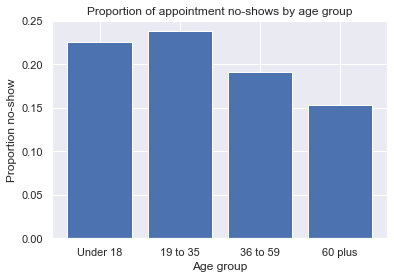

In [19]:
# Helper masks
under_18 = df['age_category'] == 'Under 18'
_19_to_35 = df['age_category'] == '19 to 35'
_36_to_59 = df['age_category'] == '36 to 59'
_60_plus = df['age_category'] == '60 plus'
is_no_show = df['no_show'] == 'Yes'

# Proportion of no-shows by age category
prop_under_18 = df[under_18 & is_no_show].size / df[under_18].size
prop_19_to_35 = df[_19_to_35 & is_no_show].size / df[_19_to_35].size
prop_36_to_60 = df[_36_to_59 & is_no_show].size / df[_36_to_59].size
prop_60_plus = df[_60_plus & is_no_show].size / df[_60_plus].size

# Create bar chart with proper labels
heights = [prop_under_18, prop_19_to_35, prop_36_to_60, prop_60_plus]
labels = ['Under 18', '19 to 35', '36 to 59', '60 plus']
title = 'Proportion of appointment no-shows by age group'
xlabel = 'Age group'
ylabel = 'Proportion no-show'

plot_bar_chart(heights, labels, title, xlabel, ylabel)

The data shows that for adults (i.e. those aged 19+), older age is associated with a reduced likelihood of not showing up to an appointment. Aside from behavioural characteristics by age group, one potential reason for this could be a greater prevalance of serious health conditions, such as those already captured in the dataset.

The youngest age group, under 18s, has a lower likelihood of missing an appointment than 19 to 35s: this is potentially due to an adult accompanying their children for such appointments, or the high importance of appointments for very young (or unborn) children. 

### Are men or women more likely to be no-shows?

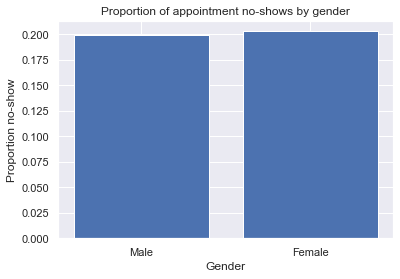

In [20]:
# Helper masks
male = df['gender'] == 'M'
female = df['gender'] == 'F'

# Proportion of no-shows by gender
prop_male = df[male & is_no_show].size / df[male].size
prop_female = df[female & is_no_show].size / df[female].size

# Create bar chart with proper labels
heights = [prop_male, prop_female]
labels = ['Male', 'Female']
title = 'Proportion of appointment no-shows by gender'
xlabel = 'Gender'
ylabel = 'Proportion no-show'

plot_bar_chart(heights, labels, title, xlabel, ylabel)

The data shows that women are marginally more likely to not show up for an appointment, although it is not clear whether the difference is statistically significant at this stage.

### Are those on welfare more or less likely to be no-shows?

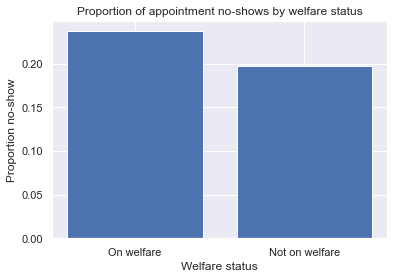

In [21]:
# Helper masks
has_welfare = df['has_scholarship'] == 1
no_welfare = df['has_scholarship'] == 0

# Proportion of no-shows by welfare status
prop_has_welfare = df[has_welfare & is_no_show].size / df[has_welfare].size
prop_no_welfare = df[no_welfare & is_no_show].size / df[no_welfare].size

# Create bar chart with proper labels
heights = [prop_has_welfare, prop_no_welfare]
labels = ['On welfare', 'Not on welfare']
title = 'Proportion of appointment no-shows by welfare status'
xlabel = 'Welfare status'
ylabel = 'Proportion no-show'

plot_bar_chart(heights, labels, title, xlabel, ylabel)

The data shows that those on welfare are more likely not to show up for an appointment. 

### Does having a medical condition or handicap make being a no-show more or less likely?

Numerous different analyses could be conducted here, including examining combinations of different conditions and/or handicaps in parallel. For the sake of simplicity, only two pieces of analysis are conducted.

First, we compare the rates of no-shows among those without any conditions with those who have each of the conditions (hypertension, diabetes or alcoholism). Note that individuals can (and do, in this dataset) have multiple conditions, although such analysis is not conducted here.

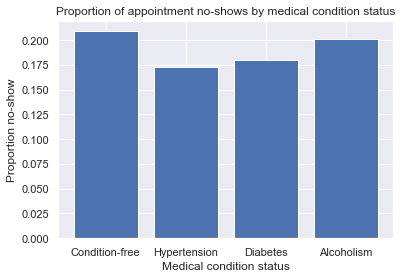

In [22]:
# Helper masks
no_conditions = df['num_conditions'] == 0
has_hypertension = df['has_hypertension'] == 1
has_diabetes = df['has_diabetes'] == 1
has_alcoholism = df['has_alcoholism'] == 1

# Proportion of no-shows by condition status
prop_no_conditions = df[no_conditions & is_no_show].size / df[no_conditions].size
prop_has_hypertension = df[has_hypertension & is_no_show].size / df[has_hypertension].size
prop_has_diabetes = df[has_diabetes & is_no_show].size / df[has_diabetes].size
prop_has_alcoholism = df[has_alcoholism & is_no_show].size / df[has_alcoholism].size

# Create bar chart with proper labels
heights = [prop_no_conditions, prop_has_hypertension, prop_has_diabetes, prop_has_alcoholism]
labels = ['Condition-free', 'Hypertension', 'Diabetes', 'Alcoholism']
title = 'Proportion of appointment no-shows by medical condition status'
xlabel = 'Medical condition status'
ylabel = 'Proportion no-show'

plot_bar_chart(heights, labels, title, xlabel, ylabel)

The data shows that patients without any of the three conditions listed are more likely to be a no-show to an appointment, which is an intuitive result. 

Individuals with hypertension or diabetes - both serious conditions which require regular monitoring - are associated with the lowest no-show rates, as might be expected.

We would also expect to see a similar pattern with handicaps, in which those with more handicaps would be less likely to be a no-show. This analysis is given below, alongside an examination of how the number of medical conditions affects the no-show rate. 

Note that the maximum number of handicaps in the dataset is 4, whilst the theoretical maximum number of conditions (using the data provided) is only 3. 

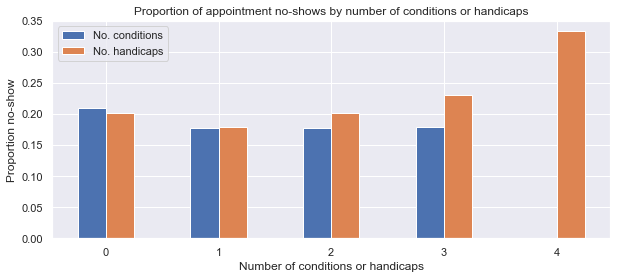

In [23]:
num_conditions = df[is_no_show].groupby('num_conditions')['num_conditions'].count()
num_conditions = num_conditions.astype(float)

for i in range(4): # Convert to proportions
    num_conditions[i] /= len(df.query('num_conditions == {}'.format(i)).index)
    
num_handicaps = df[is_no_show].groupby('num_handicaps')['num_handicaps'].count()
num_handicaps = num_handicaps.astype(float)

for i in range(5): # Convert to proportions
    num_handicaps[i] /= len(df.query('num_handicaps == {}'.format(i)).index)

num_conditions[4] = 0  # Add in missing value

title = 'Proportion of appointment no-shows by number of conditions or handicaps'
xlabel = 'Number of conditions or handicaps'
ylabel = 'Proportion no-show'

plot_grouped_bar(num_conditions, 'No. conditions', num_handicaps, 'No. handicaps', title, xlabel, ylabel)

Confirming the previous analysis, having at least one medical condition is associated with lower rates of no-shows, although having more than one is not for this dataset.

Interestingly, individuals with multiple disabilities are more likely not to show to an appointment - despite the appointment's potential relatively higher importance. This might be due to individuals with multiple disabilities sometimes not being *able* to make it to an appointment, although the exact reason is unclear. 

### To what extent does booking in advance change the likelihood of no-shows?

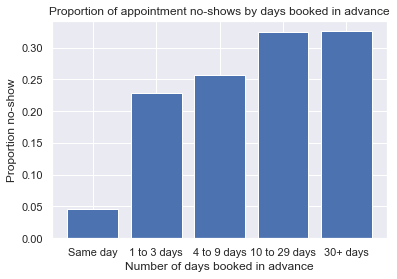

In [24]:
# Helper masks
same_day = df['days_in_advance'] == 0
_1_to_3_days = (df['days_in_advance'] >= 1) & (df['days_in_advance'] <= 3)
_4_to_9_days = (df['days_in_advance'] >= 4) & (df['days_in_advance'] <= 9)
_10_to_29_days = (df['days_in_advance'] >= 10) & (df['days_in_advance'] <= 29)
_30_plus_days = df['days_in_advance'] >= 30

# Proportion of no-shows by age category
prop_same_day = df[same_day & is_no_show].size / df[same_day].size
prop_1_to_3_days = df[_1_to_3_days & is_no_show].size / df[_1_to_3_days].size
prop_4_to_9_days = df[_4_to_9_days & is_no_show].size / df[_4_to_9_days].size
prop_10_to_29_days = df[_10_to_29_days & is_no_show].size / df[_10_to_29_days].size
prop_30_plus_days = df[_30_plus_days & is_no_show].size / df[_30_plus_days].size

# Create bar chart with proper labels
heights = [prop_same_day, prop_1_to_3_days, prop_4_to_9_days, prop_10_to_29_days, prop_30_plus_days]
labels = ['Same day', '1 to 3 days', '4 to 9 days', '10 to 29 days', '30+ days']
title = 'Proportion of appointment no-shows by days booked in advance'
xlabel = 'Number of days booked in advance'
ylabel = 'Proportion no-show'

plot_bar_chart(heights, labels, title, xlabel, ylabel)

The data shows that booking further in advance is associated with a greater likelihood of no-shows, which is an intuitive result since individuals might be more likely to forget their appointment.

SMS reminders are one method to mitigate this problem, and the dataset contains boolean data on whether an individual was sent one of these (presumably close to the appointment date e.g. 1-3 days before). 

The chart below splits the above chart according to whether an SMS reminder was sent to investigate the impact of these here. 

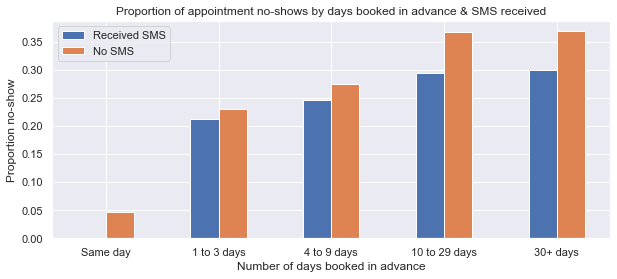

In [25]:
# Helper masks
received_SMS = df['received_SMS'] == 1
no_SMS = df['received_SMS'] == 0

# Proportion of no-shows by days_in_advance & SMS received category
same_received = 0  # SMSs not sent for appointments booked on the same day
_1_to_3_received = df[_1_to_3_days & received_SMS & is_no_show].size / df[_1_to_3_days & received_SMS].size
_4_to_9_received = df[_4_to_9_days & received_SMS & is_no_show].size / df[_4_to_9_days & received_SMS].size
_10_to_29_received = df[_10_to_29_days & received_SMS & is_no_show].size / df[_10_to_29_days & received_SMS].size
_30_plus_received = df[_30_plus_days & received_SMS & is_no_show].size / df[_30_plus_days & received_SMS].size
same_no = df[same_day & no_SMS & is_no_show].size / df[same_day & no_SMS].size
_1_to_3_no = df[_1_to_3_days & no_SMS & is_no_show].size / df[_1_to_3_days & no_SMS].size
_4_to_9_no = df[_4_to_9_days & no_SMS & is_no_show].size / df[_4_to_9_days & no_SMS].size
_10_to_29_no = df[_10_to_29_days & no_SMS & is_no_show].size / df[_10_to_29_days & no_SMS].size
_30_plus_no = df[_30_plus_days & no_SMS & is_no_show].size / df[_30_plus_days & no_SMS].size

series1 = [same_received, _1_to_3_received, _4_to_9_received, _10_to_29_received, _30_plus_received]
series1_label = 'Received SMS'
series2 = [same_no, _1_to_3_no, _4_to_9_no, _10_to_29_no, _30_plus_no]
series2_label = 'No SMS'
title = 'Proportion of appointment no-shows by days booked in advance & SMS received'
xlabel = 'Number of days booked in advance'
ylabel = 'Proportion no-show'
xticks = labels

plot_grouped_bar(series1, series1_label, series2, series2_label, title, xlabel, ylabel, xticks)

This chart shows that individuals receiving an SMS is indeed associated with a lower likelihood of being a no-show, although not sufficiently so to mitigate the increase likelihood from booking in advance. This suggests that other factors are important here, such as individuals having made other plans or sought alternative treatment in the meantime. 

<a id='conclusions'></a>
## Conclusions

A number of associations have been found in the data. In particular:

- Older individuals are generally less likely to be no-shows
- Women are marginally more likely to be no-shows, but it's not clear if this difference is statistically significant 
- Individuals on welfare are generally more likely to be no-shows 
- Having a medical condition is associated with a lower likelihood of being a no-show
- Having one disability is associated with a slightly lower likelihood of being a no-show, but having multiple disabilities is associated with a higher likelihood of being a no-show (potentially due to issues attending appointments)
- Booking further in advance is associated with a higher likelihood of being a no-show. This can be partially, but not fully, mitigated through the sending of SMS reminders. 

Note, however, that these are all correlations - and correlation does not imply causation. Further work would be needed to draw causal inferences.

Moreover, a deeper analysis which looks at more of these variables in combination would be needed to validate these findings. For example, it was hypothesised that there is a correlation between age and prevalance of the listed medical conditions, but this was not validated - and even if it were, it would not be clear which variable (or both) is causal here.